# FERNANDO LEON FRANCO

In [1]:
import os
import re
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import nltk
import numpy as np
import polars as pl
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from colorstreak import Logger
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn import metrics, preprocessing, svm
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

In [2]:
def print_bar(i, cantidad_registros, contexto="PROGRESO"):
    porcentaje = (i + 1) / cantidad_registros * 100
    # Con emojis
    barra = int(50 * (i + 1) / cantidad_registros) * "🟩"
    espacio = int(50 - len(barra)) * "⬛️"

    print(f"\r{contexto}: |{barra}{espacio}| {porcentaje:6.2f}%", end="", flush=True)

In [3]:

# ======================= Limpieza de texto =======================
def limpiar_texto(texto):
    
    texto = BeautifulSoup(texto, "html.parser").get_text()
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"@\w+", "", texto)
    texto = re.sub(r"#+", "", texto)
    stop_words = set(stopwords.words("spanish"))
    texto_limpio = [word for word in texto.split() if word not in stop_words]
    return " ".join(texto_limpio)


# ======================= Carga de datos =======================
def get_texts_from_folder(path_folder):
    tr_txt = []  # aquí van los documentos
    tr_y = []  # aquí van las etiquetas

    for file in os.listdir(path_folder):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(path_folder, file))
            root = tree.getroot()
            docs = []
            for doc in root.iter("document"):
                texto_limpio = limpiar_texto(doc.text)
                docs.append(texto_limpio)
    
            tr_txt.append(" ".join(docs))

    truth_file = os.path.join(path_folder, "truth.txt")

    file_to_label = {}
    with open(truth_file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(":::")
            # País
            
            # pais = parts[2]
            # file_to_label[parts[0]] = pais
            
            # Genero
            genero = parts[1]
            file_to_label[parts[0]] = genero



    for file in os.listdir(path_folder):
        if file.endswith(".xml"):
            file_id = file.split(".")[0]
            if file_id in file_to_label:
                tr_y.append(file_to_label[file_id])

        print_bar(len(tr_y), len(file_to_label), contexto="CARGA DE ETIQUETAS")

    return tr_txt, tr_y


In [4]:
# ======================= Carga de datos =======================
path_test = '/Users/ferleon/Github/semestre_v/procesamiento_lenguaje/data/author_profiling/es_test'
path_train = '/Users/ferleon/Github/semestre_v/procesamiento_lenguaje/data/author_profiling/es_train'
tr_txt_train, tr_y_train = get_texts_from_folder(path_train)
#tr_txt_test, tr_y_test = get_texts_from_folder(path_test)

print(f"\nTextos train: {len(tr_txt_train)}, Etiquetas train: {len(tr_y_train)}")
#print(f"Textos test: {len(tr_txt_test)}, Etiquetas test: {len(tr_y_test)}")


paises = sorted(list(set(tr_y_train)))
paises_numericas = {pais: idx for idx, pais in enumerate(paises)}




y_train = [paises_numericas[pais] for pais in tr_y_train]
#y_test = [paises_numericas[pais] for pais in tr_y_test]

/var/folders/j4/21ypxx3x0019wgj7rqnlm2340000gn/T/ipykernel_61533/549244330.py:4: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  texto = BeautifulSoup(texto, "html.parser").get_text()


CARGA DE ETIQUETAS: |🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩| 100.02%
Textos train: 4200, Etiquetas train: 4200


In [5]:
tokenizer = TweetTokenizer()
# ======================= Parámetros =======================
TOP_PALABRAS = 1_000
MAX_ITERACIONES = 1_000

# ======================= Creación del conteo de palabras por documento =======================

tokens_por_documento = []
for doc in tr_txt_train:                # baja a minúsculas, quita urls, etc.
    toks = tokenizer.tokenize(doc.lower())              # tu TweetTokenizer
    tokens_por_documento.append(toks)

print(f"Tamaño del tokens por documento: {len(tokens_por_documento)}")
print(f"Primeros 3 documentos: {tokens_por_documento[:10]}")

vocabulario_por_documento = {}
for doc in tokens_por_documento:
    palabras_unicas = set(doc)
    for token in palabras_unicas:
        vocabulario_por_documento[token] = vocabulario_por_documento.get(token, 0) + 1
Logger.debug(f"Total de palabras únicas en vocabulario: {len(vocabulario_por_documento)}")
Logger.debug(f"Vocabulario por documento: {list(vocabulario_por_documento.items())[:10]}")

# ======================= Creación del corpus de palabras =======================

corpus_de_palabras = []
for doc in tr_txt_train:
    corpus_de_palabras += tokenizer.tokenize(doc.lower())

corpus_de_palabras = [token for token in corpus_de_palabras if re.match(r"^[a-zA-ZáéíóúÁÉÍÓÚñÑ]+$", token)]

stop_words = stopwords.words('spanish')
corpus_de_palabras_clean = [token for token in corpus_de_palabras if token not in stop_words]

print(f"Tamaño del corpus de palabras: {len(corpus_de_palabras)}")
print(f"Primeros 10 tokens del corpus: {corpus_de_palabras[:10]}")

Tamaño del tokens por documento: 4200
Primeros 3 documentos: [['eln', 'asesina', 'policía', 'meten', 'bomba', 'cadáver', 'matar', 'inocentes', '.', 'y', 'aún', 'cinismo', 'hablar', 'paz', 'navidad', '.', 'infame', ',', 'injustificable', 'revolucionario', 'asesinar', 'policía', ',', 'profanar', 'cadáver', 'causar', 'heridas', 'graves', '7', 'personas', 'podría', 'ser', 'hipótesis', 'porqué', 'suicido', 'vigilante', '...', 'amigos', ',', '¿', 'qué', 'parece', '?', 'igualdad', ',', 'tolerancia', 'amor', 'van', 'ganando', '!', '!', 'gracias', 'defender', 'q', '…', 'después', 'educación', 'colombia', 'tan', 'mal', 'pensábamos', '.', 'legado', 'gina', 'parody', 'educación', 'cabeza', 'vía', 'duda', 'colombia', 'marcando', 'historia', 'mundo', 'solo', 'nobel', ',', 'sino', 'resistencia', 'pedi', '…', 'acuerdoya', 'acuerdodepaz', 'sialapaz', 'felicitaciones', 'rectores', 'docentes', 'comprometidos', 'colombia', 'mejor', 'educada', 'mejorar', '…', 'empieza', 'conteo', 'regresivo', 'q', 'empiece

In [6]:
distribucion_frecuencias = nltk.FreqDist(corpus_de_palabras)
distribucion_frecuencias_clean = nltk.FreqDist(corpus_de_palabras_clean)

vocabulario = [word for word, _ in distribucion_frecuencias.most_common(TOP_PALABRAS)]
vocabulario_clean = [word for word, _ in distribucion_frecuencias_clean.most_common(TOP_PALABRAS)]
print(f"Tamaño del vocabulario: {len(vocabulario)} | Primeras 10 palabras: {vocabulario[:10]}")
print(f"Tipo de vocabulario: {type(vocabulario)}")

dict_indices = {word: i for i, word in enumerate(vocabulario)}
dict_indices_clean = {word: i for i, word in enumerate(vocabulario_clean)}
print(f"Tipo de dict_indices: {type(dict_indices)}")
print(f"Diccionario de índices (primeras 10 entradas): {dict_indices}")

Tamaño del vocabulario: 1000 | Primeras 10 palabras: ['si', 'q', 'gracias', 'vía', 'hoy', 'ser', 'día', 'mejor', 'bien', 'así']
Tipo de vocabulario: <class 'list'>
Tipo de dict_indices: <class 'dict'>
Diccionario de índices (primeras 10 entradas): {'si': 0, 'q': 1, 'gracias': 2, 'vía': 3, 'hoy': 4, 'ser': 5, 'día': 6, 'mejor': 7, 'bien': 8, 'así': 9, 'siempre': 10, 'quiero': 11, 'vida': 12, 'ahora': 13, 'solo': 14, 'ver': 15, 'hace': 16, 'mas': 17, 'no': 18, 'tan': 19, 'hacer': 20, 'año': 21, 'años': 22, 'va': 23, 'gente': 24, 'puede': 25, 'feliz': 26, 'días': 27, 'vez': 28, 'd': 29, 'nunca': 30, 'voy': 31, 'bueno': 32, 'mal': 33, 'video': 34, 'mundo': 35, 'jajaja': 36, 'creo': 37, 'mañana': 38, 'amor': 39, 'dios': 40, 'cosas': 41, 'gran': 42, 'nuevo': 43, 'menos': 44, 'dos': 45, 'vamos': 46, 'tiempo': 47, 'buen': 48, 'cada': 49, 'alguien': 50, 'trump': 51, 'casa': 52, 'via': 53, 'y': 54, 'país': 55, 'mismo': 56, 'x': 57, 'cómo': 58, 'puedo': 59, 'verdad': 60, 'tener': 61, 'buena': 62,

In [7]:
def built_bow_tr_binario(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=np.int8)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        for word in tokens:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = 1
    return bow

In [8]:
bow_tr_binario = built_bow_tr_binario(tr_txt_train, vocabulario, dict_indices)
bow_tr_binario

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0]], shape=(4200, 1000), dtype=int8)

# Ejercicio 1 | Clasificación de autores usando Bag of Words Binario

In [9]:
x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_tr_binario, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_binario, rec_bow_binario, f1_bow_binario, _ = precision_recall_fscore_support(y_val_20, y_pred, average='weighted')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))


[[307 113]
 [109 311]]
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       420
           1       0.73      0.74      0.74       420

    accuracy                           0.74       840
   macro avg       0.74      0.74      0.74       840
weighted avg       0.74      0.74      0.74       840



# Ejercicio 2 | Clasificación de autores usando Bag of Words Frecuencia

In [10]:
def built_bow_tr_frecuencia(tr_txt, vocabulario, dict_indices):
    bow = np.zeros((len(tr_txt), len(vocabulario)), dtype=int)
    for cont_doc, tr in enumerate(tr_txt):
        if not tr or not isinstance(tr, str):
            continue
        tokens = tokenizer.tokenize(tr.lower())
        fdist_doc = nltk.FreqDist(tokens)
        for word in fdist_doc:
            if word in dict_indices:
                bow[cont_doc, dict_indices[word]] = fdist_doc[word]
    return bow

In [11]:
# 1) TF: tu función tal cual
bow_train_frecuencia = built_bow_tr_frecuencia(tr_txt_train, vocabulario, dict_indices).astype(float)
print(f"BoW de frecuencia (shape): {bow_train_frecuencia.shape}")

# 2) DF: usando tokens_por_documento que ya generaste
N = len(tokens_por_documento)  # número de documentos
df = np.zeros(len(dict_indices), dtype=int)

for doc in tokens_por_documento:
    presentes = set()
    for tok in doc:
        j = dict_indices.get(tok)
        if j is not None:
            presentes.add(j)
    for j in presentes:
        df[j] += 1


idf = np.log((1.0 + N) / (1.0 + df)) + 1.0


bow_tfidf = bow_train_frecuencia * idf[None, :] 


normas = np.linalg.norm(bow_tfidf, axis=1, keepdims=True) + 1e-12
bow_tfidf = bow_tfidf / normas

print(f"TF-IDF listo (shape): {bow_tfidf.shape}")
print(f"Primeras filas TF-IDF:\n{bow_tfidf[:3, :10]}")

BoW de frecuencia (shape): (4200, 1000)
TF-IDF listo (shape): (4200, 1000)
Primeras filas TF-IDF:
[[0.0664401  0.05019459 0.05017668 0.21092238 0.03054518 0.03004373
  0.01653018 0.13992789 0.06491482 0.08281611]
 [0.06952428 0.         0.1093873  0.         0.05993082 0.03929797
  0.12973143 0.         0.         0.06499536]
 [0.         0.         0.         0.76241538 0.         0.
  0.         0.         0.         0.        ]]


In [12]:
x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_frecuencia, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES)
grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_frecuencia, rec_bow_frecuencia, f1_bow_frecuencia, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))


/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ferleon/

[[298 122]
 [128 292]]
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       420
           1       0.71      0.70      0.70       420

    accuracy                           0.70       840
   macro avg       0.70      0.70      0.70       840
weighted avg       0.70      0.70      0.70       840



In [13]:
x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_tfidf, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES)
grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_tfidf, rec_bow_tfidf, f1_bow_tfidf, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))

[[308 112]
 [104 316]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       420
           1       0.74      0.75      0.75       420

    accuracy                           0.74       840
   macro avg       0.74      0.74      0.74       840
weighted avg       0.74      0.74      0.74       840



# Ejercicio 3 | Clasificación de autores usando Bag of Words Binario y normalización L2

In [14]:

bow_train_L2 = normalize(bow_tr_binario, norm='l2')

x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_L2, y_train, test_size=0.2, stratify=y_train)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES)

grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_binario_l2, rec_bow_binario_l2, f1_bow_binario_l2, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))

[[298 122]
 [111 309]]
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       420
           1       0.72      0.74      0.73       420

    accuracy                           0.72       840
   macro avg       0.72      0.72      0.72       840
weighted avg       0.72      0.72      0.72       840



# Ejercicio 4 | Clasificación de autores usando Bag of Words Frecuencia y normalización L2

In [15]:
bow_train_frecuencia_L2 = normalize(bow_train_frecuencia, norm='l2')

x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(bow_train_frecuencia_L2, y_train, test_size=0.2, stratify=y_train, random_state=42)

parametros = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=MAX_ITERACIONES)
grid = GridSearchCV(estimator=svr, param_grid=parametros, n_jobs=4, scoring='f1_macro', cv=5)
grid.fit(x_train_80, y_train_80)
y_pred = grid.predict(x_val_20)

prec_bow_frecuencia_L2, rec_bow_frecuencia_L2, f1_bow_frecuencia_L2, _ = precision_recall_fscore_support(y_val_20, y_pred, average='macro')

print(confusion_matrix(y_val_20, y_pred))
print(metrics.classification_report(y_val_20, y_pred))

[[306 114]
 [104 316]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       420
           1       0.73      0.75      0.74       420

    accuracy                           0.74       840
   macro avg       0.74      0.74      0.74       840
weighted avg       0.74      0.74      0.74       840



In [16]:
def ganador_metricas( etiquetas, precisiones, f1_scores):
    max_prec = max(precisiones)
    max_f1 = max(f1_scores)
    
    if max_prec >= max_f1:
        indice_ganador = precisiones.index(max_prec)
        return etiquetas[indice_ganador], max_prec
    else:
        indice_ganador = f1_scores.index(max_f1)
        return etiquetas[indice_ganador], max_f1


etiquetas = ['BOW Binario', 'BOW Frecuencia', 'BOW TF-IDF', 'BOW Binario + L2', 'BOW Frecuencia + L2' ]



# ======================= Tabla comparativa =======================
tabla_comparativa = {
    'Experimento': etiquetas,
    'Accuracy': [prec_bow_binario, prec_bow_frecuencia, prec_bow_tfidf, prec_bow_binario_l2, prec_bow_frecuencia_L2,],
    'F1-Score (Macro)': [f1_bow_binario, f1_bow_frecuencia, f1_bow_tfidf, f1_bow_binario_l2, f1_bow_frecuencia_L2,],
    'F1-Score (Weighted)': [f1_bow_binario, f1_bow_frecuencia, f1_bow_tfidf, f1_bow_binario_l2, f1_bow_frecuencia_L2,],
    'Precisión (Macro)': [prec_bow_binario, prec_bow_frecuencia, prec_bow_tfidf, prec_bow_binario_l2, prec_bow_frecuencia_L2,]
}

df_comparativo = pl.DataFrame(tabla_comparativa)

print("TABLA COMPARATIVA DE LOS 4 EJERCICIOS")
print("=" * 50)
print(df_comparativo)
print("=" * 50)

ganador = ganador_metricas(etiquetas, tabla_comparativa['Precisión (Macro)'], tabla_comparativa['F1-Score (Macro)'])
print(f"Gano el modelo basado en: {ganador[0]} con un valor de: {ganador[1]:.4f}")

TABLA COMPARATIVA DE LOS 4 EJERCICIOS
shape: (5, 5)
┌─────────────────────┬──────────┬──────────────────┬─────────────────────┬───────────────────┐
│ Experimento         ┆ Accuracy ┆ F1-Score (Macro) ┆ F1-Score (Weighted) ┆ Precisión (Macro) │
│ ---                 ┆ ---      ┆ ---              ┆ ---                 ┆ ---               │
│ str                 ┆ f64      ┆ f64              ┆ f64                 ┆ f64               │
╞═════════════════════╪══════════╪══════════════════╪═════════════════════╪═══════════════════╡
│ BOW Binario         ┆ 0.735736 ┆ 0.735708         ┆ 0.735708            ┆ 0.735736          │
│ BOW Frecuencia      ┆ 0.702422 ┆ 0.702366         ┆ 0.702366            ┆ 0.702422          │
│ BOW TF-IDF          ┆ 0.742945 ┆ 0.742834         ┆ 0.742834            ┆ 0.742945          │
│ BOW Binario + L2    ┆ 0.722772 ┆ 0.722571         ┆ 0.722571            ┆ 0.722772          │
│ BOW Frecuencia + L2 ┆ 0.740613 ┆ 0.740439         ┆ 0.740439            ┆ 0.740613

# VECTORES DE PALABRAS MÁS IMPORTANTES

In [17]:
bow_train_frecuencia_clean = built_bow_tr_frecuencia(tr_txt_train,vocabulario_clean,dict_indices_clean)
print(bow_train_frecuencia_clean)
bow_train_frecuencia_clean.shape

[[5 2 3 ... 0 0 0]
 [4 0 5 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [9 3 3 ... 0 0 0]
 [8 0 0 ... 0 0 0]
 [8 0 9 ... 0 0 0]]


(4200, 1000)

In [18]:
def compute_dor_profe(TR):
    DTR = np.zeros((TR.shape[1], TR.shape[0]), dtype=float)

    tam_v = TR.shape[1] # Tamaño del vocabulario TOTAL
    
    for i,doc in enumerate(TR):
        non_zero_positions = np.nonzero(doc)[0] # Esto me dice las dimensiones que no son cero
        tamaño_vocabulario = len(non_zero_positions)
        for termino in non_zero_positions:
            DTR[termino, i] = doc[termino] * np.log(tam_v / tamaño_vocabulario)
    return DTR

In [19]:
dor = compute_dor_profe(bow_train_frecuencia_clean)

dor_normalizado_clean = preprocessing.normalize(dor, norm='l2')

print(dor_normalizado_clean.shape)

(1000, 4200)


In [20]:

feature_selector = SelectKBest(chi2, k=1000)

# Aprende a como hacer selección de las palabras de manera muy interesante en automatico les da la relevancia
feature_selector = SelectKBest(chi2, k=1000)
feature_selector.fit(bow_train_frecuencia, y_train)
best = feature_selector.get_support(indices=True)

In [21]:
best

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [22]:
dict_indices_invertido_clean = {valor: key for key, valor in dict_indices_clean.items()}
dict_indices_invertido_clean

{0: 'si',
 1: 'q',
 2: 'gracias',
 3: 'vía',
 4: 'hoy',
 5: 'ser',
 6: 'día',
 7: 'mejor',
 8: 'bien',
 9: 'así',
 10: 'siempre',
 11: 'quiero',
 12: 'vida',
 13: 'ahora',
 14: 'solo',
 15: 'ver',
 16: 'hace',
 17: 'mas',
 18: 'tan',
 19: 'hacer',
 20: 'año',
 21: 'años',
 22: 'va',
 23: 'gente',
 24: 'puede',
 25: 'feliz',
 26: 'días',
 27: 'vez',
 28: 'd',
 29: 'nunca',
 30: 'voy',
 31: 'bueno',
 32: 'mal',
 33: 'video',
 34: 'mundo',
 35: 'jajaja',
 36: 'creo',
 37: 'mañana',
 38: 'amor',
 39: 'dios',
 40: 'cosas',
 41: 'gran',
 42: 'nuevo',
 43: 'menos',
 44: 'dos',
 45: 'vamos',
 46: 'tiempo',
 47: 'buen',
 48: 'cada',
 49: 'alguien',
 50: 'trump',
 51: 'casa',
 52: 'via',
 53: 'país',
 54: 'mismo',
 55: 'x',
 56: 'cómo',
 57: 'puedo',
 58: 'verdad',
 59: 'tener',
 60: 'buena',
 61: 'da',
 62: 'ir',
 63: 'venezuela',
 64: 'igual',
 65: 'buenos',
 66: 'nadie',
 67: 'dice',
 68: 'aquí',
 69: 'gobierno',
 70: 'amo',
 71: 'semana',
 72: 'jajajaja',
 73: 'pues',
 74: 'cuenta',
 75: 'fa

In [23]:
t_words = [dict_indices_invertido_clean[index] for index in best]
# dict_indices {"palabra": "dimension_en_bow",...}
matris_objetivo_clean = np.array([dor_normalizado_clean[dict_indices_clean[word]] for word in t_words])
matris_objetivo_clean

array([[0.01074891, 0.00884984, 0.        , ..., 0.02248801, 0.02065033,
        0.01661654],
       [0.00251642, 0.        , 0.        , ..., 0.0043872 , 0.        ,
        0.        ],
       [0.00412967, 0.00708346, 0.        , ..., 0.00479988, 0.        ,
        0.01196998],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(1000, 4200))

In [24]:
matris_objetivo_clean.shape

(1000, 4200)

In [25]:
dor_normalizado_clean.shape

(1000, 4200)

In [26]:
from sklearn.manifold import TSNE


reduce_matrix = TSNE(n_components=2).fit_transform(matris_objetivo_clean)

max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)


In [27]:
from sklearn.manifold import TSNE


reduce_matrix = TSNE(n_components=2).fit_transform(matris_objetivo_clean)
reduce_matrix

array([[ -1.582036 ,   8.629247 ],
       [ 13.283506 ,   7.4677696],
       [ 13.214817 , -25.808979 ],
       ...,
       [-23.039515 ,   2.2659683],
       [-10.55781  , -29.724821 ],
       [ -4.3709006,  18.506657 ]], shape=(1000, 2), dtype=float32)

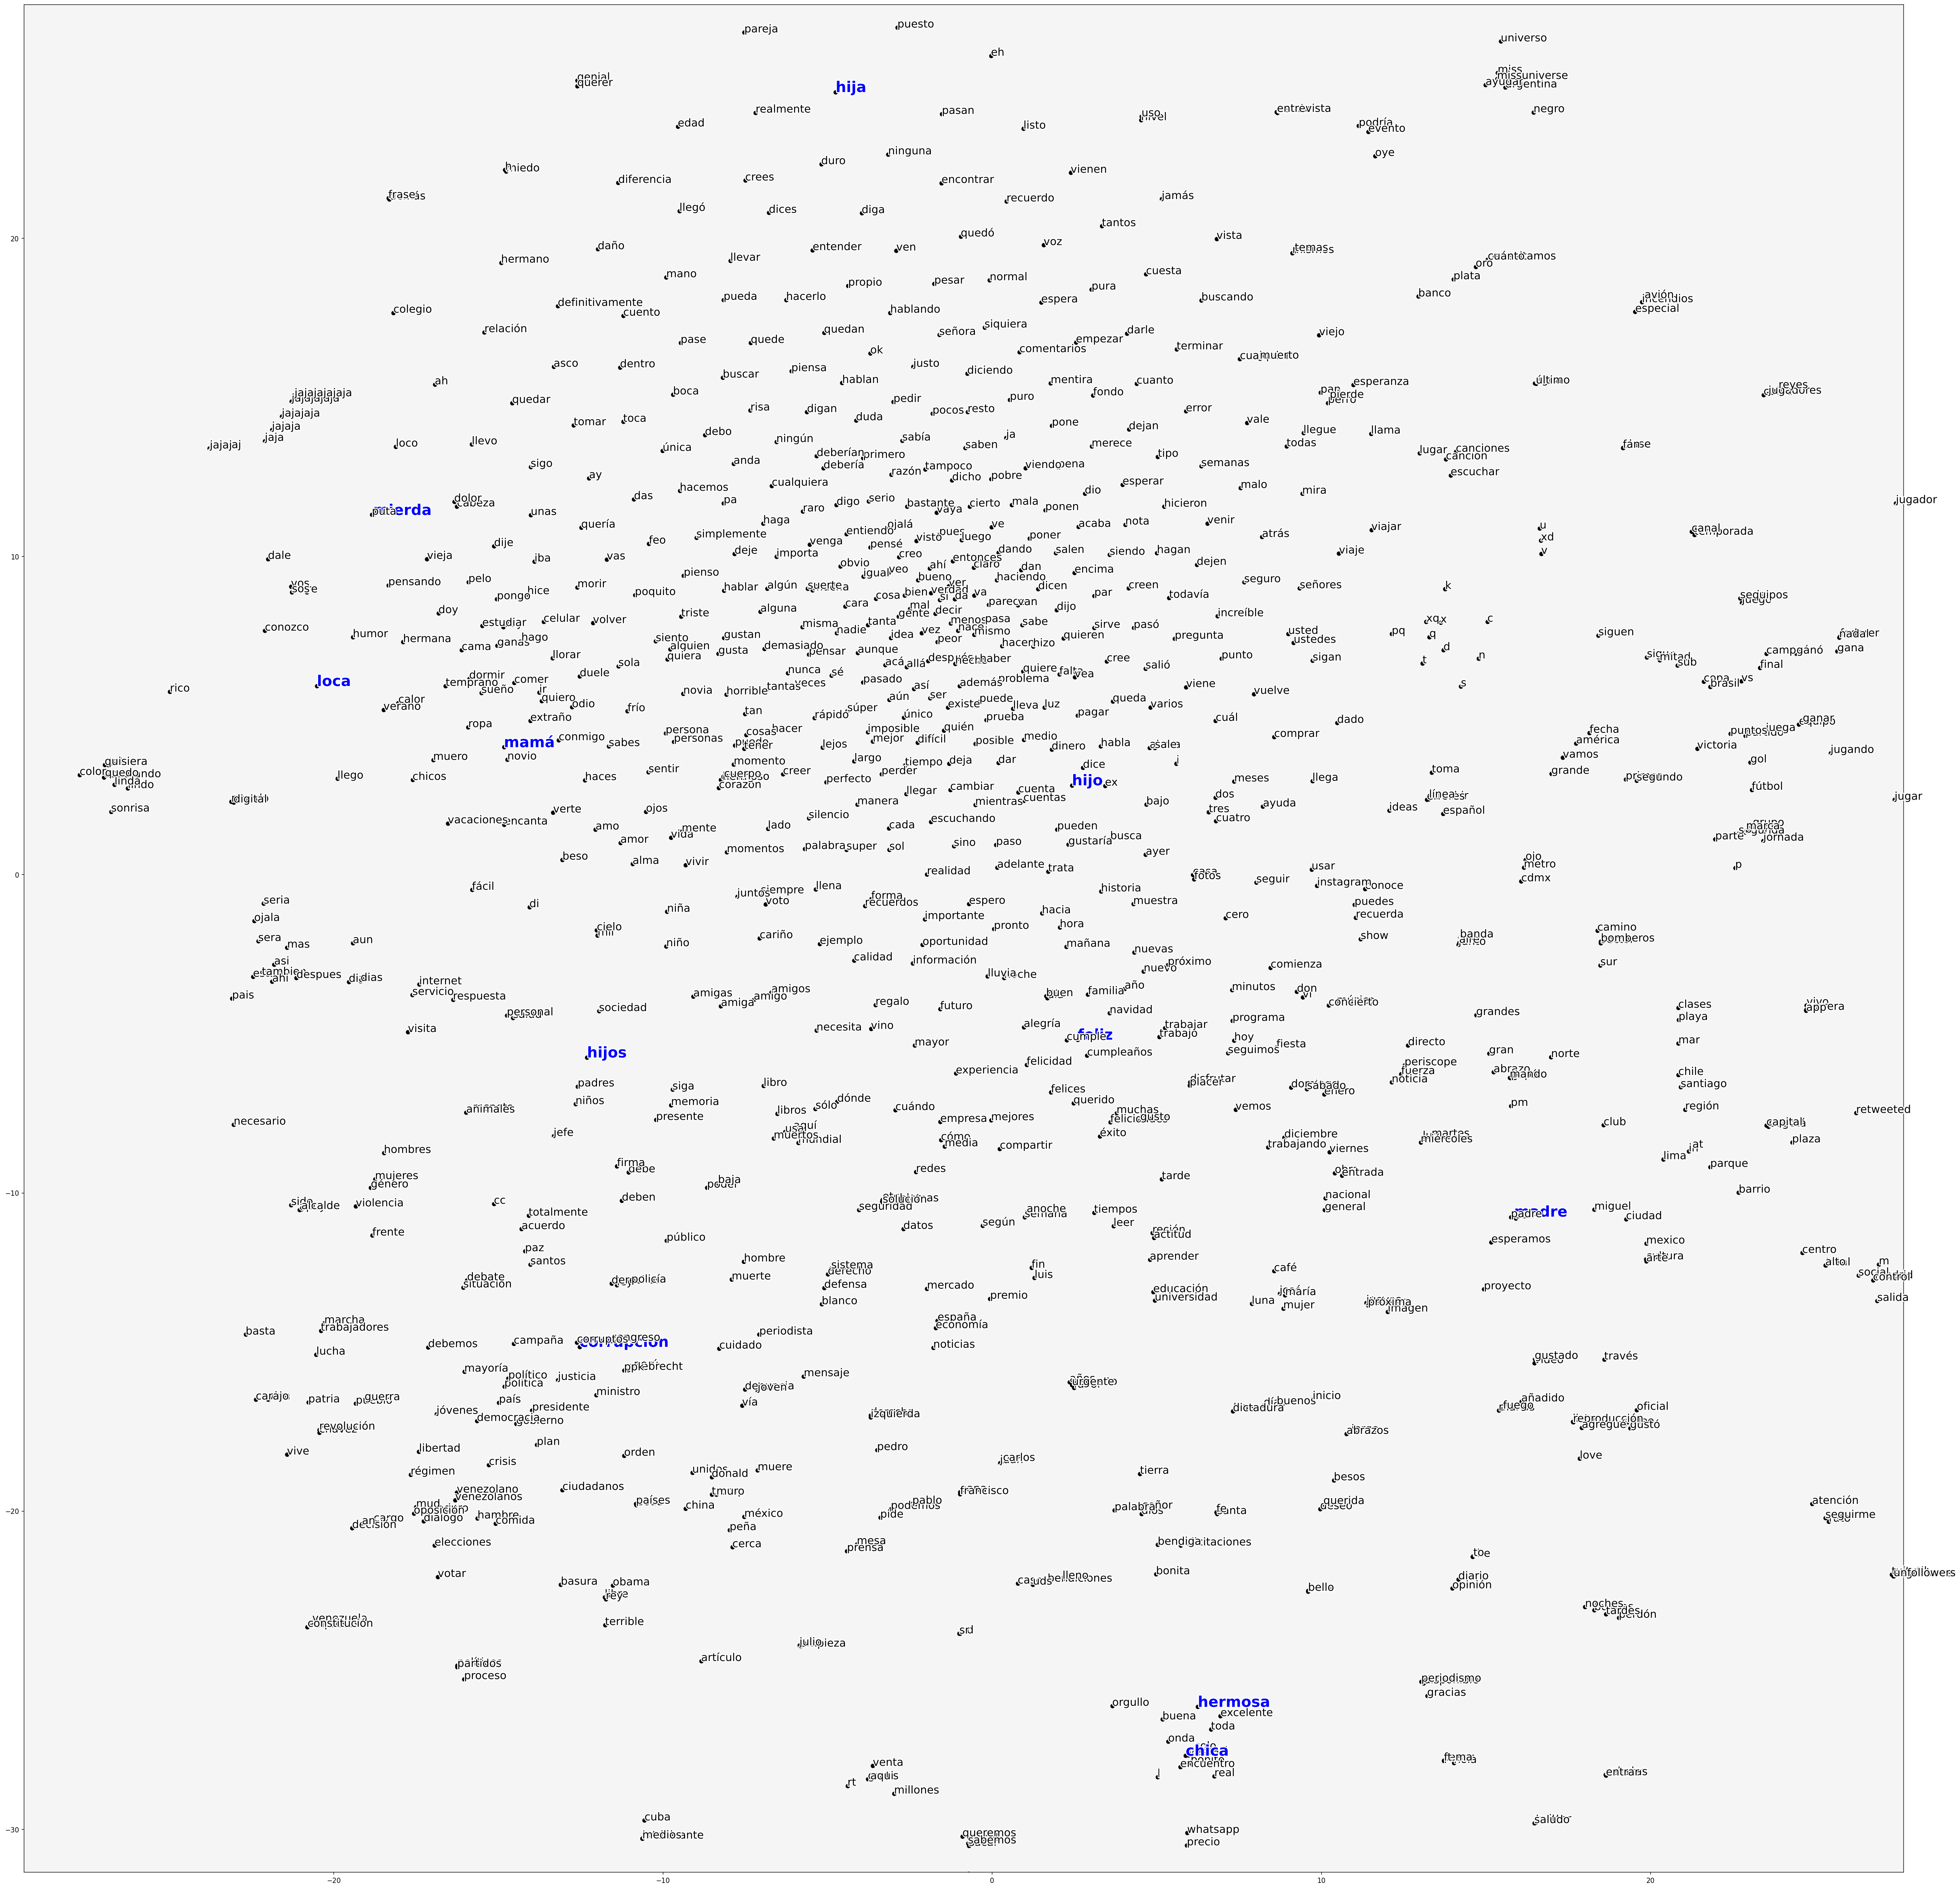

In [28]:
from matplotlib import patheffects

x, y = reduce_matrix[:, 0], reduce_matrix[:, 1]

plt.figure(figsize=(50, 50), dpi=120)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.scatter(x, y, s=30, color='black')






stop_words = stopwords.words('spanish')


for i, word in enumerate(t_words):
    if word in stop_words:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=18, 
            color='red', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    elif word in ['politicos', 'corrupción', 'PRI', 'feliz', 
              'hermosa', 'chica', 'tu', 'hdp','madre','madres',
              '@usuario' ,'hijos', 'pendeja', 'pendejo','mierda', 
              'loca', 'hijo', 'hija', 'mamá', 'tía']:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=22, 
            color='blue', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    else:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=16, 
            color='black',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )

plt.gca().set_facecolor('whitesmoke')
plt.show()


In [29]:
len(t_words)

1000

PROGRESO: |🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩| 100.00%
[DEBUG] Palabras a graficar: ['feliz', 'mierda', 'madre', 'hermosa', 'hijo', 'corrupción', 'mamá', 'hijos', 'padre', 'papá', 'loca', 'hija', 'chica']
[DEBUG] Coordenadas: [array([ 2.5991158, -5.1878242], dtype=float32), array([-18.799448,  11.300637], dtype=float32), array([ 15.8556  , -10.749988], dtype=float32), array([  6.2491817, -26.15667  ], dtype=float32), array([2.4267194, 2.8045335], dtype=float32), array([-12.533642, -14.842254], dtype=float32), array([-14.82804 ,   4.002982], dtype=float32), array([-12.302483 ,  -5.7492185], dtype=float32), array([ 15.76101  , -10.7673645], dtype=float32), array([15.763502, -6.390347], dtype=float32), array([-20.507933 ,   5.9251056], dtype=float32), array([-4.750848, 24.591864], dtype=float32), array([  5.8795705, -27.690731 ], dtype=float32)]


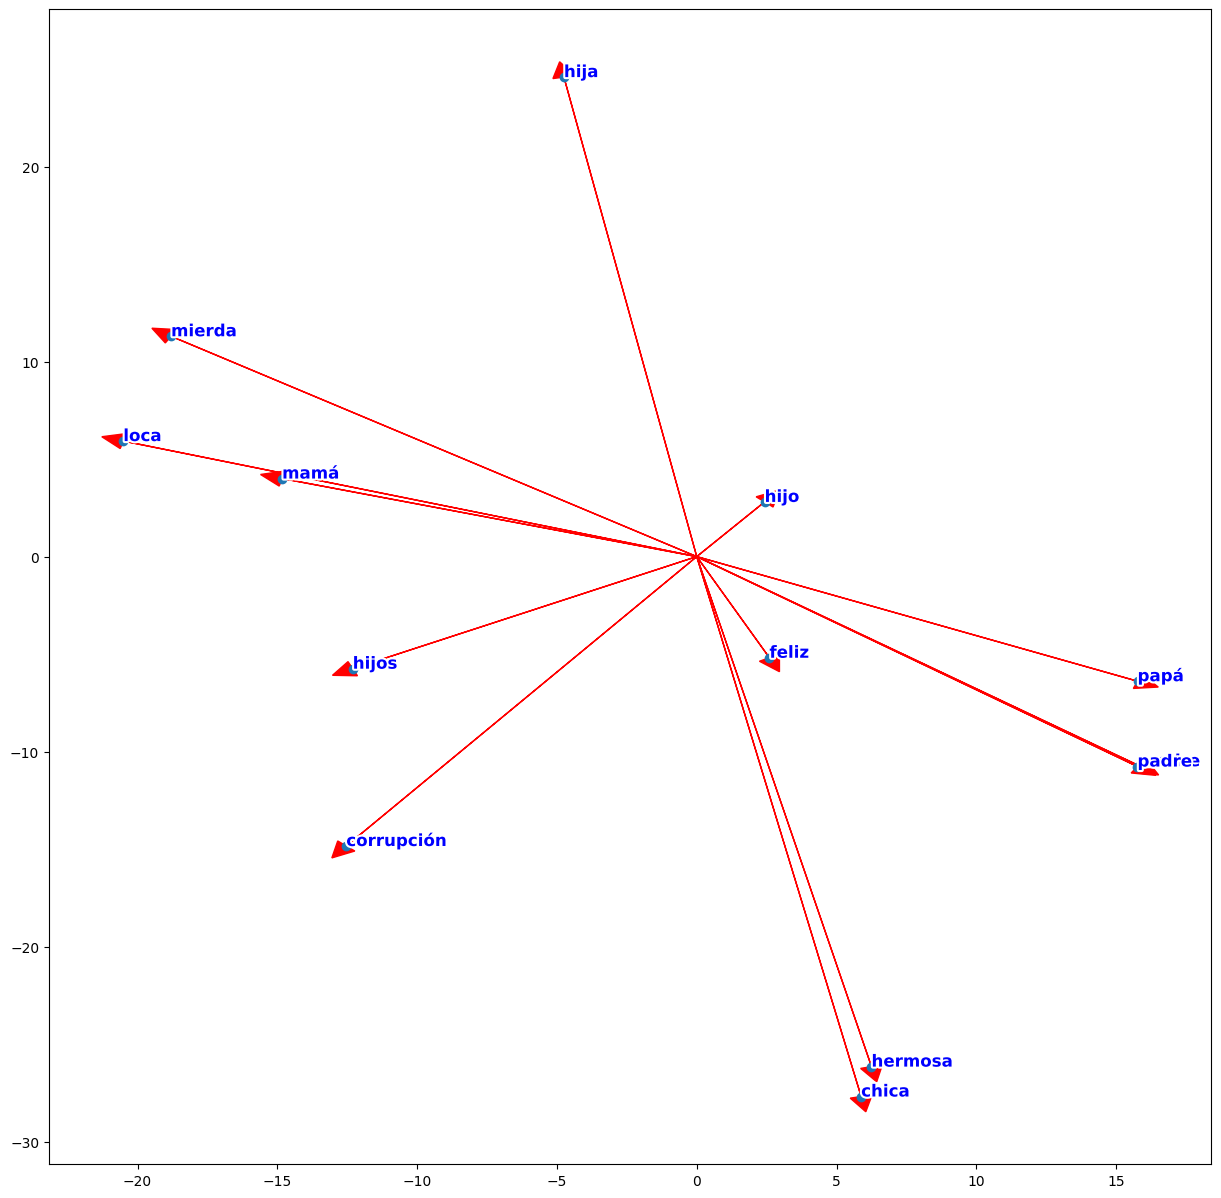

In [30]:
subsetword = ['politicos', 'corrupción', 'PRI', 'feliz', 
              'hermosa', 'chica', 'tu', 'hdp','madre','madres',
              '@usuario' ,'hijos', 'pendeja', 'pendejo','mierda', 
              'loca', 'hijo', 'hija', 'mamá', 'tía','padre','papá']

# t_words Las 1,000 mejores palabras según chi2 ( Algoritmo de selección de características)
# reduce_matriz Aquí estan las 1,000 mejores palabras en dos dimensiones

subreduce_matriz = []
ploted_subsetwords = []


for idx, word in enumerate(t_words):
    if word in subsetword:
        subreduce_matriz.append(reduce_matrix[idx])
        ploted_subsetwords.append(word)
    print_bar(idx, len(t_words), contexto="PROGRESO")

print()
Logger.debug(f"Palabras a graficar: {ploted_subsetwords}")
Logger.debug(f"Coordenadas: {subreduce_matriz}")

# Convertir a numpy array
subreduce_matriz = np.array(subreduce_matriz)


# Hacemos la gráfica de flechas
fig , ax = plt.subplots(figsize=(15, 15))

for word in subreduce_matriz:
    ax.arrow(0, 0, word[0], word[1], head_width=0.8, head_length=0.8, fc='red', ec='red', width=0.1e-2)
    ax.annotate(
        ploted_subsetwords[subreduce_matriz.tolist().index(word.tolist())], 
        (word[0], word[1]), 
        fontsize=12, 
        color='blue', 
        fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
    )

ax.scatter(subreduce_matriz[:,0], subreduce_matriz[:,1])

# NUBE DE PALABRAS

[DEBUG]  Diccionario invertido de índices : {0: 'si', 1: 'q', 2: 'gracias', 3: 'vía', 4: 'hoy', 5: 'ser', 6: 'día', 7: 'mejor', 8: 'bien', 9: 'así', 10: 'siempre', 11: 'quiero', 12: 'vida', 13: 'ahora', 14: 'solo', 15: 'ver', 16: 'hace', 17: 'mas', 18: 'tan', 19: 'hacer', 20: 'año', 21: 'años', 22: 'va', 23: 'gente', 24: 'puede', 25: 'feliz', 26: 'días', 27: 'vez', 28: 'd', 29: 'nunca', 30: 'voy', 31: 'bueno', 32: 'mal', 33: 'video', 34: 'mundo', 35: 'jajaja', 36: 'creo', 37: 'mañana', 38: 'amor', 39: 'dios', 40: 'cosas', 41: 'gran', 42: 'nuevo', 43: 'menos', 44: 'dos', 45: 'vamos', 46: 'tiempo', 47: 'buen', 48: 'cada', 49: 'alguien', 50: 'trump', 51: 'casa', 52: 'via', 53: 'país', 54: 'mismo', 55: 'x', 56: 'cómo', 57: 'puedo', 58: 'verdad', 59: 'tener', 60: 'buena', 61: 'da', 62: 'ir', 63: 'venezuela', 64: 'igual', 65: 'buenos', 66: 'nadie', 67: 'dice', 68: 'aquí', 69: 'gobierno', 70: 'amo', 71: 'semana', 72: 'jajajaja', 73: 'pues', 74: 'cuenta', 75: 'favor', 76: 'personas', 77: 'desp

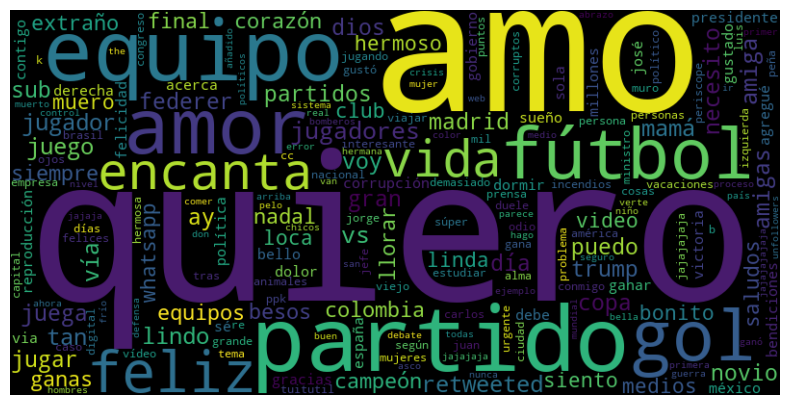

In [31]:

# Chi2
feature_selector = SelectKBest(chi2, k=1000)
feature_selector.fit(bow_train_frecuencia_clean, y_train) # EL y_train son los paises 


dict_indices_invertido_clean = {valor: key for key, valor in dict_indices_clean.items()}
Logger.debug(f" Diccionario invertido de índices : {dict_indices_invertido_clean}")

# Extraer las palabras seleccionadas
palabras_mejores_indices = feature_selector.get_support(indices=True)
palabras = [dict_indices_invertido_clean[indice] for indice in palabras_mejores_indices]


# Extraer los scores
chi2_scores = feature_selector.scores_
best_scores = chi2_scores[palabras_mejores_indices] # type: ignore
Logger.debug(f" Puntajes Chi2 de las mejores palabras: {best_scores}")


# Distribución de k mejores palabras
distribucion_k_mejores_tweets = {palabra: score for palabra, score in zip(palabras, best_scores)} # type: ignore
mejores_50 = dict(sorted(distribucion_k_mejores_tweets.items(), key=lambda item: item[1], reverse=True)[:500])
Logger.debug(f"Frecuencia de palabras en tweets: {mejores_50}")


# Generar y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(mejores_50)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [32]:
# ======================= TCOR (Lavelli) con misma interfaz de uso =======================
from collections import Counter
from scipy import sparse
import numpy as np
from sklearn.preprocessing import normalize as sk_normalize

def compute_tcor_profe(tokens_por_documento, dict_indices, min_pair_count=1):
    """
    Construye TCOR según Lavelli:
      w_{k,j} = (1 + log #(k,j)) * log(|T| / T_k)
    Co-ocurrencia por DOCUMENTO (pares únicos por doc). Devuelve CSR (|V| x |V|).
    """
    V = len(dict_indices)
    pair_counts = Counter()
    vecinos = [set() for _ in range(V)]

    # 1) Contar co-ocurrencias por documento (sin duplicar dentro del doc)
    for toks in tokens_por_documento:
        idxs = [dict_indices[t] for t in toks if t in dict_indices]
        if not idxs:
            continue
        uniq = sorted(set(idxs))
        for a in range(len(uniq)):
            i = uniq[a]
            for b in range(a+1, len(uniq)):
                j = uniq[b]
                pair_counts[(i, j)] += 1
                vecinos[i].add(j); vecinos[j].add(i)

    if not pair_counts:
        raise ValueError("No se encontraron co-ocurrencias con el vocabulario dado.")

    # 2) Matriz simétrica dispersa de conteos
    rows, cols, data = [], [], []
    for (i, j), c in pair_counts.items():
        if c >= min_pair_count:
            rows += [i, j]; cols += [j, i]; data += [c, c]
    C = sparse.coo_matrix((data, (rows, cols)), shape=(V, V)).tocsr()

    # 3) tff(i,j) = 1 + log(count)
    C.data = 1.0 + np.log(C.data)

    # 4) Escalado por fila con log(|T| / T_k), T_k = #vecinos únicos de k
    Tk = np.array([max(1, len(S)) for S in vecinos], dtype=float)
    s_k = np.log((V) / Tk)                 # |T| = V
    S = sparse.diags(s_k, format="csr")
    TCOR = S @ C

    # 5) Limpieza
    TCOR.setdiag(0)
    TCOR.eliminate_zeros()
    return TCOR

In [33]:
# Antes tenías:
# dor = compute_dor_profe(bow_train_frecuencia_clean)
# dor_normalizado_clean = preprocessing.normalize(dor, norm='l2')

# Ahora:
tcor = compute_tcor_profe(tokens_por_documento, dict_indices_clean, min_pair_count=1)
tcor_normalizado_clean = preprocessing.normalize(tcor, norm='l2')  # término×término, L2 por fila

print(tcor_normalizado_clean.shape)

(1000, 1000)


In [34]:
feature_selector = SelectKBest(chi2, k=1000)
feature_selector.fit(bow_tfidf, y_train)  # o bow_train_frecuencia, como prefieras
best = feature_selector.get_support(indices=True)

dict_indices_invertido_clean = {v:k for k,v in dict_indices_clean.items()}
t_words = [dict_indices_invertido_clean[idx] for idx in best]

In [35]:
# Índices de las palabras seleccionadas en el vocab limpio
idx_words = [dict_indices_clean[w] for w in t_words]

# Igual que con DOR: toma las filas de esas palabras
# (opción A — filas contra TODO el vocab; puede ser grande si |V| es grande)
# matris_objetivo_clean = tcor_normalizado_clean[idx_words, :].toarray()

# Mejor para estabilidad/tiempo: filas y columnas en las mismas 1000 palabras (1000x1000)
tcor_1k = tcor_normalizado_clean[idx_words][:, idx_words].toarray()
matris_objetivo_clean = tcor_1k

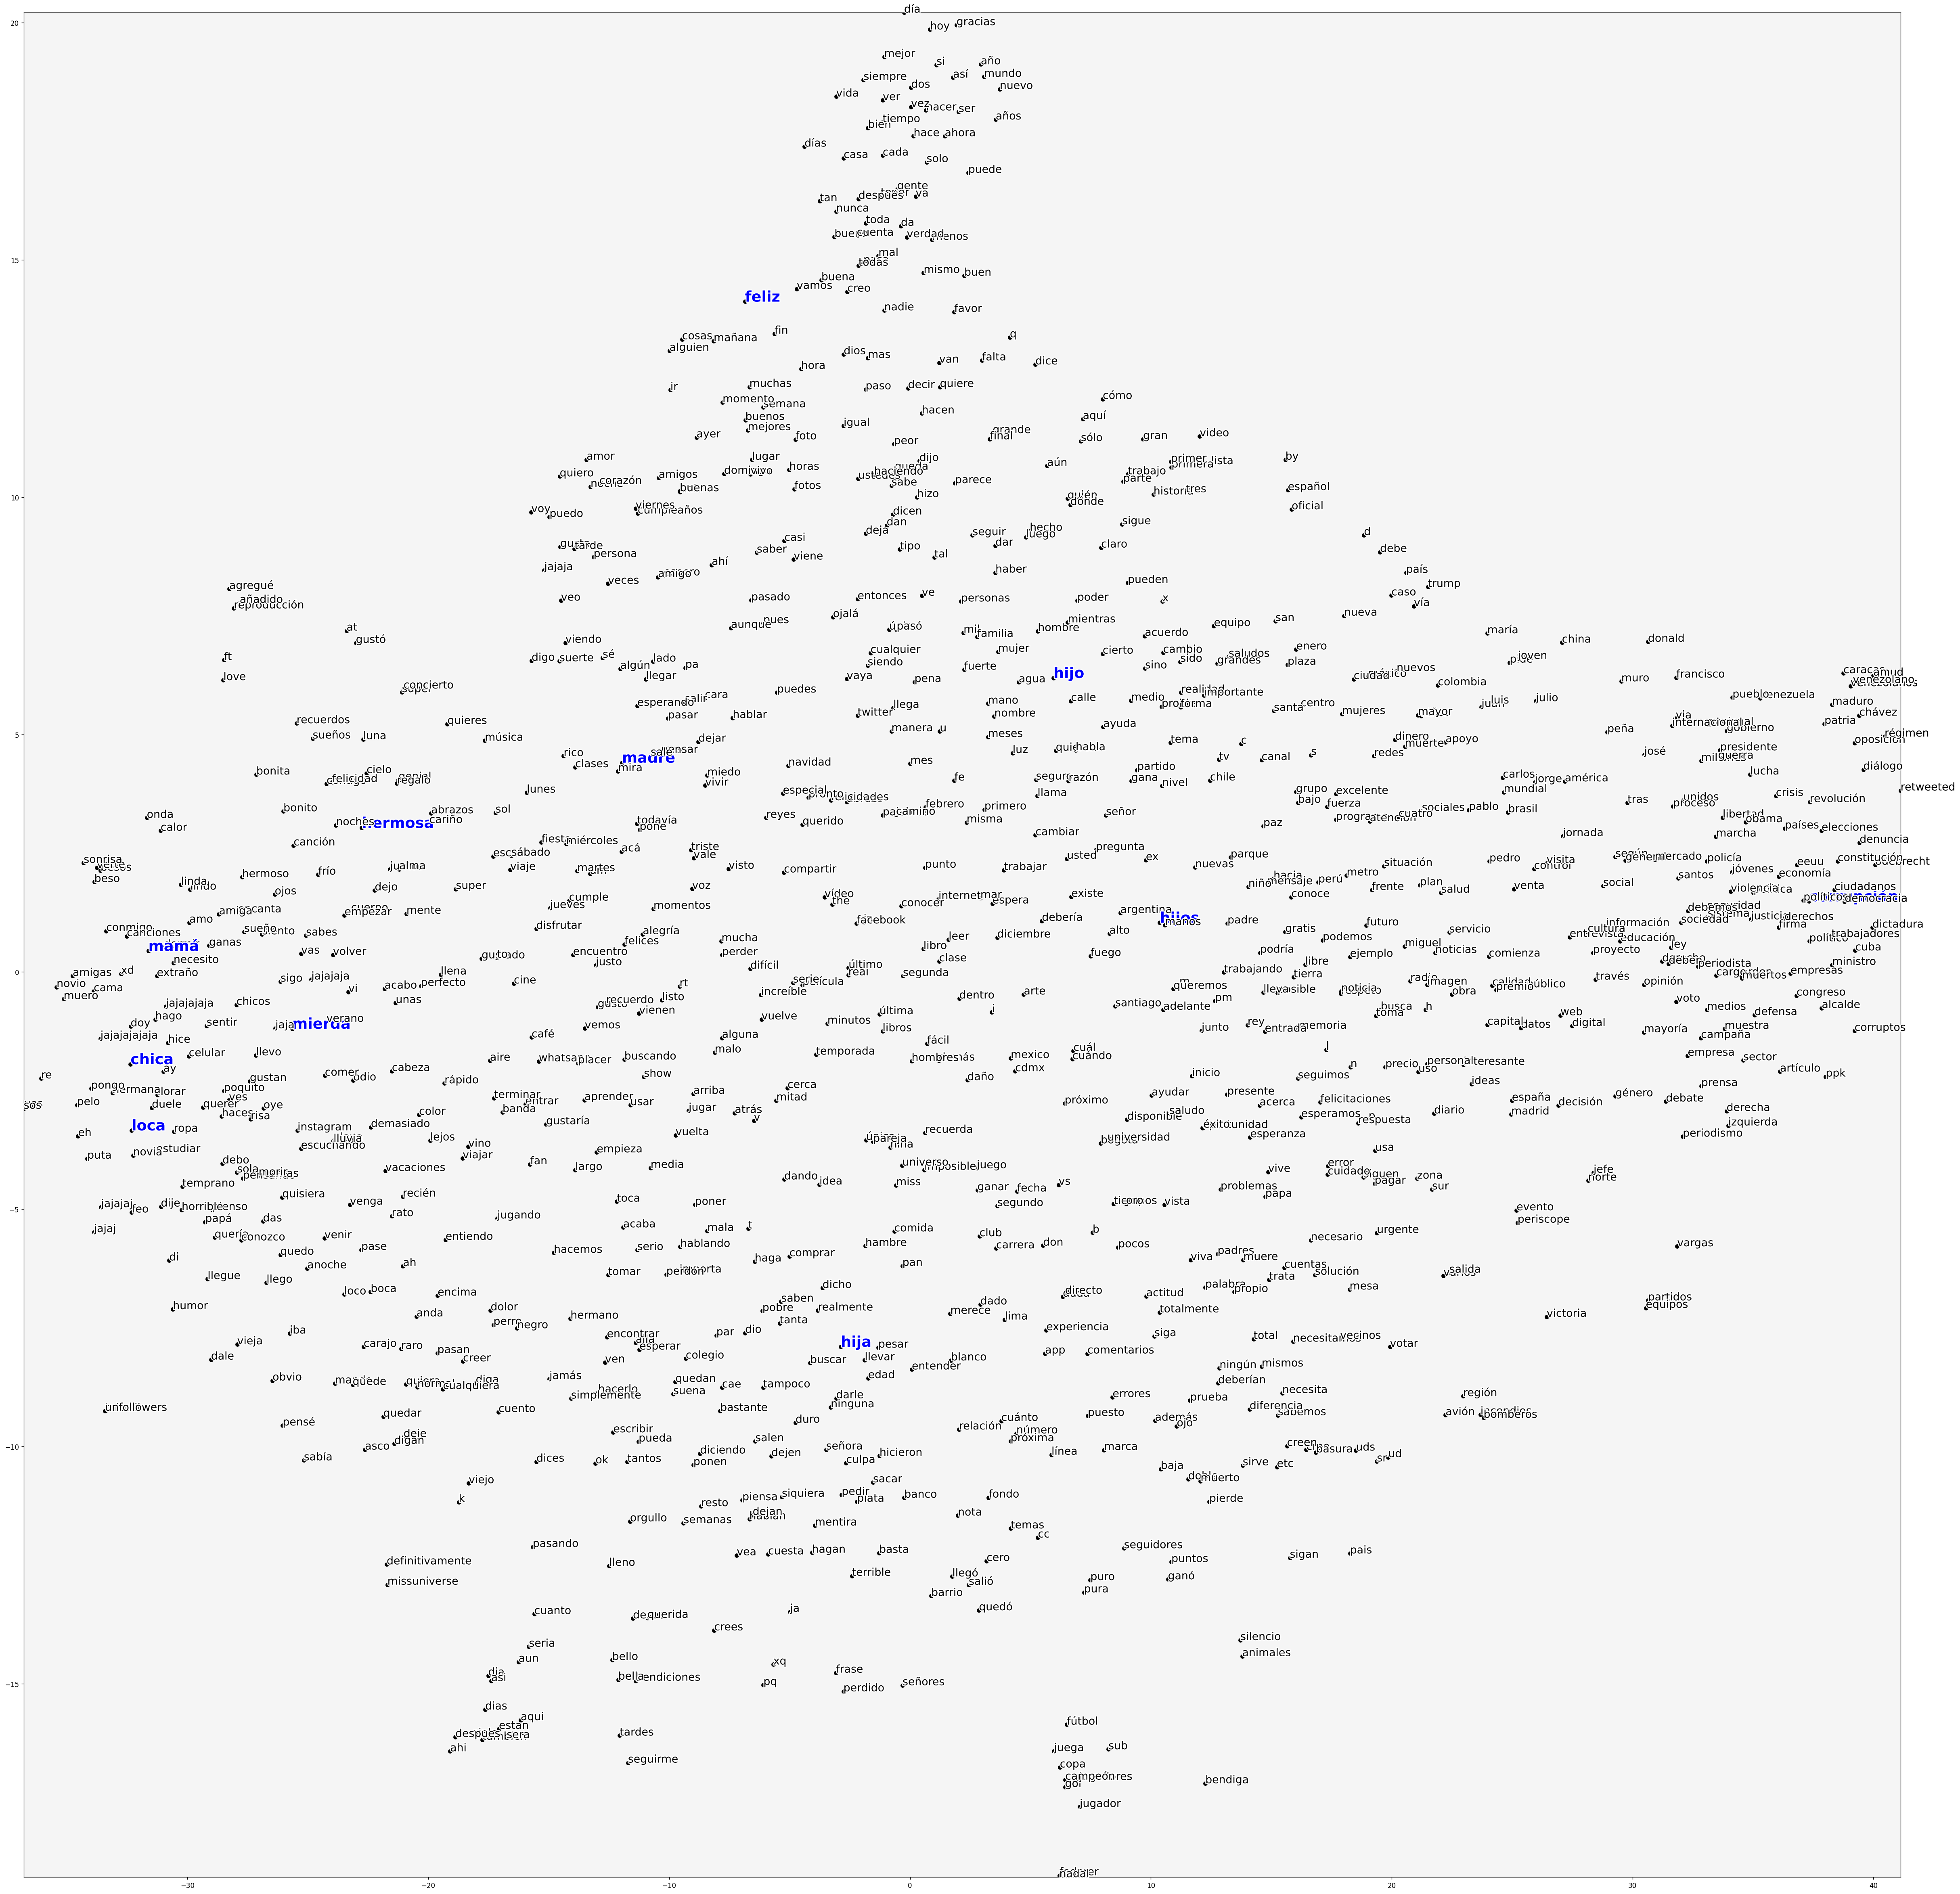

In [36]:
from sklearn.manifold import TSNE

reduce_matrix = TSNE(n_components=2, init="pca", random_state=42, perplexity=30, learning_rate="auto", max_iter=1000)\
                .fit_transform(matris_objetivo_clean)

max_x, max_y = np.max(reduce_matrix, axis=0)
min_x, min_y = np.min(reduce_matrix, axis=0)

# Tu misma rutina de anotado
from matplotlib import patheffects
x, y = reduce_matrix[:,0], reduce_matrix[:,1]

plt.figure(figsize=(50,50), dpi=120)
plt.xlim(min_x, max_x); plt.ylim(min_y, max_y)
plt.scatter(x, y, s=30, color='black')

stop_words_es = stopwords.words('spanish')
for i, word in enumerate(t_words):
    if word in stop_words_es:
        plt.annotate(word, (x[i],y[i]), fontsize=18, color='red', fontweight='bold',
                     path_effects=[patheffects.withStroke(linewidth=3, foreground="white")])
    elif word in ['politicos','corrupción','PRI','feliz','hermosa','chica','tu','hdp','madre','madres',
                  '@usuario','hijos','pendeja','pendejo','mierda','loca','hijo','hija','mamá','tía']:
        plt.annotate(word, (x[i],y[i]), fontsize=22, color='blue', fontweight='bold',
                     path_effects=[patheffects.withStroke(linewidth=3, foreground="white")])
    else:
        plt.annotate(word, (x[i],y[i]), fontsize=16, color='black',
                     path_effects=[patheffects.withStroke(linewidth=3, foreground="white")])

plt.gca().set_facecolor('whitesmoke')
plt.show()